<a href="https://colab.research.google.com/github/jiangli001/walmart-sales-prediction/blob/main/Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages

In [ ]:
# General Utilities
import pandas as pd
import numpy as np
from scipy import stats
import random
from sklearn import preprocessing
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot

# Evaluation and validation 
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, train_test_split
from sklearn.metrics import mean_squared_error

TensorFlow is already loaded. Please restart the runtime to change versions.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/Retail/Data/'

'Features data set.csv'  'sales data-set.csv'  'stores data-set.csv'


# Loading Data

In [ ]:
# Read Data
Features = pd.read_csv('/content/drive/My Drive/Retail/Data/Features data set.csv', 
                       parse_dates=['Date'])
# Sum up markdowns as promotion
Features[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = Features[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0).astype('float64')
Features['Promotion'] = Features[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(sum, axis = 1)
Features.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], inplace = True, axis = 1)

# Assign 0 to NA values
Sales = pd.read_csv('/content/drive/My Drive/Retail/Data/sales data-set.csv', parse_dates = ['Date'])
Stores = pd.read_csv('/content/drive/My Drive/Retail/Data/stores data-set.csv')
display(Features.head(),Sales.head(),Stores.head())

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Promotion
0,1,2010-05-02,42.31,2.572,211.096358,8.106,False,0.0
1,1,2010-12-02,38.51,2.548,211.242170,8.106,True,0.0
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False,0.0
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False,0.0
4,1,2010-05-03,46.50,2.625,211.350143,8.106,False,0.0


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# Cleaning Data


## Merging Datasets

In [ ]:
# Merge 'Features' table and 'Sales' table
Alldt = pd.merge(Features, Sales, 
                 how ='outer', 
                 left_on=('Store', 'Date','IsHoliday'), 
                 right_on=('Store', 'Date','IsHoliday'))
Alldt.dropna(inplace=True)
Alldt.reset_index(inplace=True, drop=True)

# Group weekly sales based on store and date 
# Predict sales on a store-wide level instead of a department-wide level
sumsales = pd.DataFrame(Alldt.groupby(['Store','Date'])['Weekly_Sales'].sum())
sumsales.reset_index(inplace = True)
Alldt = pd.merge(Features, sumsales, how='right', left_on=('Store', 'Date'), 
                 right_on=('Store', 'Date'))
Alldt = Alldt.sort_values(by = ['Store','Date'])
sumsales.reset_index(inplace = True, drop=True)

# Merge Alldt and Stores data
Alldt = pd.merge(Alldt, Stores, how ='outer', left_on='Store', right_on='Store')
Alldt = Alldt[['Store','Type','Size', 'Date','IsHoliday','Promotion',
               'Temperature','Fuel_Price', 'CPI', 'Unemployment','Weekly_Sales']]

# Convert the boolean values of 'IsHoliday' to binary numbers
def convertTrueFalse(x):
  if x == True:
    IsHoliday = 1
  else:
    IsHoliday = 0
  return IsHoliday

Alldt['IsHoliday'] = Alldt['IsHoliday'].map(convertTrueFalse)

Alldt['Year'], Alldt['Month'] = Alldt.Date.dt.year, Alldt.Date.dt.month

Alldt = Alldt[['Store','Type','Size', 'Date','Year','Month','IsHoliday','Promotion', 
               'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Weekly_Sales']]

print('There are {} rows.'.format(len(Alldt)))
display(Alldt.head())
print('\n\n\n')
display(Alldt.describe())

There are 6435 rows.


,Store,Type,Size,Date,Year,Month,IsHoliday,Promotion,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,A,151315,2010-01-10,2010,1,0,0.0,71.89,2.603,211.671989,7.838,1453329.50
1,1,A,151315,2010-02-04,2010,2,0,0.0,62.27,2.719,210.820450,7.808,1594968.28
2,1,A,151315,2010-02-07,2010,2,0,0.0,80.91,2.669,211.223533,7.787,1492418.14
3,1,A,151315,2010-02-19,2010,2,0,0.0,39.93,2.514,211.289143,8.106,1611968.17
4,1,A,151315,2010-02-26,2010,2,0,0.0,46.63,2.561,211.319643,8.106,1409727.59


,Store,Size,Year,Month,IsHoliday,Promotion,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6.435000e+03
mean,23.000000,130287.600000,2010.965035,6.475524,0.069930,6267.753417,60.663782,3.358607,171.578394,7.999151,1.046965e+06
std,12.988182,63117.022465,0.797019,3.321797,0.255049,14269.377364,18.444933,0.459020,39.356712,1.875885,5.643666e+05
min,1.000000,34875.000000,2010.000000,1.000000,0.000000,0.000000,-2.060000,2.472000,126.064000,3.879000,2.099863e+05
25%,12.000000,70713.000000,2010.000000,4.000000,0.000000,0.000000,47.460000,2.933000,131.735000,6.891000,5.533501e+05
50%,23.000000,126512.000000,2011.000000,6.000000,0.000000,0.000000,62.670000,3.445000,182.616521,7.874000,9.607460e+05
75%,34.000000,202307.000000,2012.000000,9.000000,0.000000,6844.640000,74.940000,3.735000,212.743293,8.622000,1.420159e+06
max,45.000000,219622.000000,2012.000000,12.000000,1.000000,160510.610000,100.140000,4.468000,227.232807,14.313000,3.818686e+06


## Removing Outliers

In [ ]:
# Reomve outlier of sales
z = np.abs(stats.zscore(Alldt['Weekly_Sales']))
# Arbitrarily set the threshold that gives 99% probability
threshold = 2.58 
idx = [i for i in np.where(z > threshold)[0]]
Alldt_remove_outlier = Alldt.drop(index = idx, axis = 0)
Alldt_remove_outlier.reset_index(drop = True, inplace = True)
print('There are {} rows.'.format(len(Alldt_remove_outlier)))
display(Alldt_remove_outlier.head())

There are 6384 rows.


,Store,Type,Size,Date,Year,Month,IsHoliday,Promotion,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,A,151315,2010-01-10,2010,1,0,0.0,71.89,2.603,211.671989,7.838,1453329.50
1,1,A,151315,2010-02-04,2010,2,0,0.0,62.27,2.719,210.820450,7.808,1594968.28
2,1,A,151315,2010-02-07,2010,2,0,0.0,80.91,2.669,211.223533,7.787,1492418.14
3,1,A,151315,2010-02-19,2010,2,0,0.0,39.93,2.514,211.289143,8.106,1611968.17
4,1,A,151315,2010-02-26,2010,2,0,0.0,46.63,2.561,211.319643,8.106,1409727.59


# Descriptive Analysis

## Exploratory Graphs

In [ ]:
# From this chart, we can tell they differentiate store type by size 
fig = px.box(Alldt_remove_outlier, x = 'Type', y = 'Size')
fig.show()

In [ ]:
# Relationship between Type and Sales
fig1 = px.box(Alldt_remove_outlier, x = 'Type', y = 'Weekly_Sales')
fig1.show()

In [ ]:

# Relationship between Holiday and Sales
fig2 = px.violin(Alldt_remove_outlier, x = 'IsHoliday', y = 'Weekly_Sales')
fig2.show()

In [ ]:
## Relationship between Holiday, Type, and Sales. To see which type of store's sales is affected by holiday the most.
## set a new column has type and holiday, for example, if it's a A type and Holiday week, the value is A_1

def combine_type_holiday(x):
  Type_Holiday = str(x['Type'])+ '_' + str(x['IsHoliday']) 
  return Type_Holiday

fig3_df = Alldt.copy()
fig3_df['Type_Holiday'] = fig3_df[['IsHoliday','Type']].apply(combine_type_holiday, axis = 1)

## calculate the differences of mean sales of each Type_Holiday
diff = pd.DataFrame({'A': [0], 'B':[0], 'C':[0]})
meansales = fig3_df.groupby(['Type','IsHoliday'])['Weekly_Sales'].mean()
for column in diff.columns:
  diff[column] = meansales[column][1]/meansales[column][0] - 1
   
display(diff)
print('\n\n Type {} stores are most affected by holiday.'.format(diff.columns[np.argmax(np.array(diff.iloc[0]))]))

## Plot the box 
fig3 = px.violin(fig3_df, x='Type', y='Weekly_Sales', color='IsHoliday')
fig3.show()


,A,B,C
0,0.073272,0.106313,-0.003836




 Type B stores are most affected by holiday.


In [ ]:
fig4 = px.area(Alldt.groupby(by=['Date','Type'],as_index=False).sum(), 
               x='Date', y="Weekly_Sales", color ="Type")
fig4.show()

In [ ]:
fig5_df = Alldt.copy()
fig5_df['Year'] = fig5_df['Date'].map(lambda x: x.strftime('%Y')) 
fig5_df = fig5_df.groupby(by=['Year','Type'], as_index=False).sum()
fig5 = px.bar(fig5_df, x='Year', y='Weekly_Sales', color='Type', barmode='group',  template= 'ggplot2')
fig5.show()

## Statistical Analysis

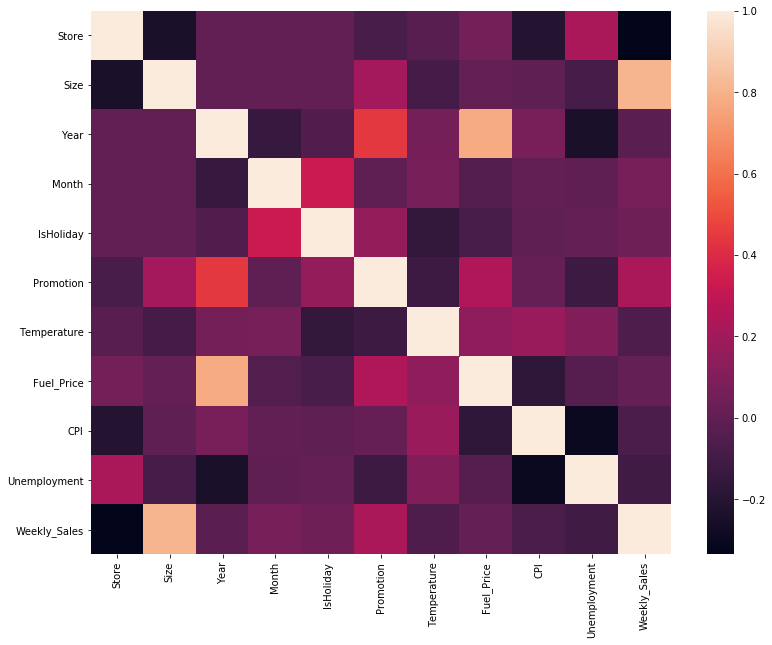

In [ ]:
# Check pairwise correlations between all variable
correlation = Alldt.corr()
plt.figure(figsize=(13, 10))
fig6 = sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns)
plt.show(fig6)

In [ ]:
fig7 = px.scatter(Alldt, y="Weekly_Sales", x="Fuel_Price", color="Type",
                  hover_name="Type", trendline="ols")
fig7.show()

# Fit a linear regression between store type and fuel price
results = px.get_trendline_results(fig7)
for t in results['Type']:
  print('*************************************************************')
  print('Regression of {}\n'.format(t))
  pvalue = results[results.Type == t].px_fit_results.iloc[0].pvalues[1]
  if pvalue <= 0.05:
    print('Sales of type {} stores are related to fuel price\n'.format(t))
  else:
    print('Sales of type {} stores are NOT related to fuel price\n'.format(t))
  print(results[results.Type == t].px_fit_results.iloc[0].summary())

*************************************************************
Regression of A

Sales of type A stores are NOT related to fuel price

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.099
Date:                Mon, 02 Mar 2020   Prob (F-statistic):             0.0785
Time:                        02:25:42   Log-Likelihood:                -45933.
No. Observations:                3146   AIC:                         9.187e+04
Df Residuals:                    3144   BIC:                         9.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [ ]:
fig8 = px.scatter(Alldt, y="Weekly_Sales", x="Promotion", color="Type",
                 hover_name="Type", trendline="ols")
fig8.show()

# Fit a linear regression between store type and promotion
results = px.get_trendline_results(fig8)
for t in results['Type']:
  print('*************************************************************')
  print('Regression of {}\n'.format(t))
  pvalue = results[results.Type == t].px_fit_results.iloc[0].pvalues[1]
  if pvalue <= 0.05:
    print('Sales of type {} stores are related to promotions.\n'.format(t))
  else:
    print('Sales of type {} stores are NOT related to Promotions.\n'.format(t))
  print(results[results.Type == t].px_fit_results.iloc[0].summary())
  print('\n\n')

*************************************************************
Regression of A

Sales of type A stores are related to promotions.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     123.2
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           4.19e-28
Time:                        02:25:43   Log-Likelihood:                -45875.
No. Observations:                3146   AIC:                         9.175e+04
Df Residuals:                    3144   BIC:                         9.177e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [ ]:
fig = make_subplots(rows=3, cols=2)

trace0 = go.Histogram(x=Alldt_remove_outlier['Size'],name="Size")
trace1 = go.Histogram(x=Alldt_remove_outlier['Promotion'],name="Promotion")
trace2 = go.Histogram(x=Alldt_remove_outlier['Temperature'],name="Temperature")
trace3 = go.Histogram(x=Alldt_remove_outlier['Fuel_Price'],name="Fuel Price")
trace4 = go.Histogram(x=Alldt_remove_outlier['CPI'],name="CPI")
trace5 = go.Histogram(x=Alldt_remove_outlier['Unemployment'],name="Unemployment")

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)
fig.append_trace(trace5, 3, 2)

fig.update_layout(title_text="Histogram of Select Variables")
fig.show()

# Prediction Models


In [ ]:
print(Alldt['Type'].value_counts()) # check values of 'Type' column
final_df = pd.get_dummies(Alldt, columns=['Type']) # One-hot encoding
final_df = final_df[['Store', 'Year','Month' , 'Size', 'IsHoliday', 'Promotion', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Type_A', 'Type_B', 'Type_C', 'Weekly_Sales']]

A    3146
B    2431
C     858
Name: Type, dtype: int64


In [ ]:
# Splitting the data into training, validating, and testing sets
X = final_df.iloc[:,2:-1]
y = final_df['Weekly_Sales']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=8)

## Random Forest

### Hyper-parameter Tuning

In [ ]:
rfr_param = {'n_estimators':[100,200,300,400,500],
             'max_depth':[5,10,15,20,25]}
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=8), param_grid=rfr_param, cv=5)
grid_rfr.fit(X_val, y_val)
print('Best parameters: {}'.format(grid_rfr.best_params_))
print('Best CV score: {:.2f}'.format(grid_rfr.best_score_))

Best parameters: {'max_depth': 20, 'n_estimators': 400}
Best CV score: 0.91


In [ ]:
results = pd.DataFrame(grid_rfr.cv_results_)
np.array(results.mean_test_score).reshape(5,5)
display(results.head())
scores = np.array(results.mean_test_score).reshape(5,5)
fig = go.Figure(data=go.Heatmap(z=scores, 
                                x=[100,200,300,400,500],
                                y=[5,10,15,20,25],
                                colorscale='thermal'))
fig.update_layout(xaxis_title='n_estimators', yaxis_title='max_depth')
fig.show()

### Cross-Validation

In [ ]:
print(grid_rfr.best_estimator_)

In [ ]:
rfr = grid_rfr.best_estimator_
kfold = KFold(n_splits=10, shuffle=True, random_state=8)
# Fit the entire training set with the best parameters and get its performance on the testing set
scores = cross_validate(rfr, X, y, cv=kfold, scoring=('r2', 'neg_mean_squared_error'))

print("The average R-squared of the 10 CVs is: {:.3f}".format(np.mean(scores['test_r2'])))
print("The average MSE of the 10 CVs is: {:,.0f}".format(np.abs(np.mean(scores['test_neg_mean_squared_error']))))
print("The average Root MSE of the 10 CVs is: {:,.0f}".format(np.sqrt(np.abs(np.mean(scores['test_neg_mean_squared_error'])))))

### Prediction

In [ ]:
# Plot differences between pred and test
rfr.fit(X_trainval,y_trainval)
y_pred_rfr = rfr.predict(X_test)
testdt = pd.DataFrame({'ytest': y_test, 
                       'ypred': y_pred_rfr,
                       'pred_error': (y_pred_rfr-y_test)/y_test*100})

ax1 = px.line(x=range(0, len(testdt)), y = testdt.pred_error)
ax2 = px.violin(y = testdt.pred_error)

ax1.update_layout(title_text='Difference between Predicted and Actual Values')
ax2.update_layout(title_text='Difference between Predicted and Actual Values')

ax1.show()
ax2.show()

## Gradient Boosting Decision Tree

### Hyper-parameter Tuning

In [ ]:
gbm_param = {'learning_rate':[0.1,0.05,0.01,0.005,0.001],
             'n_estimators':[100,300,500,700,900],
             'max_depth':[2,4,6,8,10]}
grid_gbm = GridSearchCV(GradientBoostingRegressor(random_state=8), param_grid = gbm_param, cv=5)
grid_gbm.fit(X_val, y_val)
print('Best parameters: {}'.format(grid_gbm.best_params_))
print('Best CV score: {:.2f}'.format(grid_gbm.best_score_))

### Cross-Validation

In [ ]:
print(grid_gbm.best_estimator_)
print(kfold)

NameError: ignored

In [ ]:
gbm = grid_gbm.best_estimator_
# Fit the entire training set with the best parameters and get its performance on the testing set
scores = cross_validate(gbm, X, y, cv=kfold, scoring=('r2', 'neg_mean_squared_error'))

print("The average R-squared of the 10 CVs is: {:.3f}".format(np.mean(scores['test_r2'])))
print("The average MSE of the 10 CVs is: {:,.0f}".format(np.abs(np.mean(scores['test_neg_mean_squared_error']))))
print("The average Root MSE of the 10 CVs is: {:,.0f}".format(np.sqrt(np.abs(np.mean(scores['test_neg_mean_squared_error'])))))

### Prediction

In [ ]:
gbm.fit(X_trainval, y_trainval)
y_pred_gbm = gbm.predict(X_test)
testdt = pd.DataFrame({'ytest': y_test, 
                       'ypred': y_pred_gbm,
                       'pred_error': (y_pred_gbm-y_test)/y_test*100})

ax1 = px.line(x=range(len(testdt)), y=testdt.pred_error)
ax2 = px.violin(y=testdt.pred_error)

ax1.update_layout(title_text='Difference between Predicted and Actual Values')
ax2.update_layout(title_text='Difference between Predicted and Actual Values')

ax1.show()
ax2.show()

In [ ]:
feature_importance = gbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Neural Network

### Build the Neural Network

In [ ]:
def build_model(features):
  model = keras.Sequential()
  model.add(layers.Dense(64, activation=tf.nn.relu, input_shape=(features.shape[-1],)))
  model.add(layers.Dense(64, activation=tf.nn.relu))
  model.add(layers.Dense(64, activation=tf.nn.relu))
  model.add(layers.Dense(1, activation='linear'))
  OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
  model.compile(loss='MSE', optimizer=OPTIMIZER, metrics=['MSE','MAE'])
  return model

In [ ]:
net = build_model(X_train)
print(net.summary())
print("\n The shape of the training set is: ", X_train.shape)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________
None

 The shape of the training set is:  (4633, 11)


### Train the model

In [ ]:
class ProgressBar(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if (epoch+1) % 10 == 0:
      print(' Epoch', epoch+1, 'finished.') 
    else:
      print('*', end='')

In [ ]:
batch_size = 256
number_of_epochs = 50

model_history = net.fit(x=X_train, 
                        y=y_train, 
                        batch_size=batch_size, 
                        epochs=number_of_epochs, 
                        verbose=0, 
                        validation_data=(X_test,y_test),
                        callbacks=[ProgressBar(),
                                   EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.001, 
                                                  patience=5,
                                                  mode='min')])

********* Epoch 10 finished.
********* Epoch 20 finished.
******

In [ ]:
hist_df = pd.DataFrame(model_history.history, index=model_history.epoch)
display(hist_df.tail())

,loss,mean_squared_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_error
21,1.110338e+11,1.110338e+11,253620.500000,1.099719e+11,1.099719e+11,248252.312500
22,1.111058e+11,1.111058e+11,253437.734375,1.106639e+11,1.106639e+11,248269.593750
23,1.112037e+11,1.112037e+11,253458.203125,1.076414e+11,1.076414e+11,251184.765625
24,1.112022e+11,1.112022e+11,254195.484375,1.105454e+11,1.105454e+11,248261.468750
25,1.112292e+11,1.112292e+11,253196.796875,1.076560e+11,1.076560e+11,249223.781250


In [ ]:
fig = make_subplots(cols=3)
fig.append_trace(go.Scatter(x=hist_df.index,y=hist_df['mean_squared_error'], name='MSE'), row=1, col=1)
fig.append_trace(go.Scatter(x=hist_df.index,y=hist_df['loss'], name='loss'), row=1, col=2)
fig.append_trace(go.Scatter(x=hist_df.index,y=hist_df['mean_absolute_error'], name='MAE'), row=1, col=3)
fig.update_layout(xaxis_title='Epoch')
fig.show()

In [ ]:
loss, MSE, MAE = net.evaluate(x=X_test, y=y_test, batch_size=256, verbose=0)

print('Mean Absolute Error is {:,.0f}'.format(MAE))
print('Mean Squred Error is {:,.0f}'.format(MSE))
print('Loss is {:,.0f}'.format(loss))                                                                        
print('Root Mean Squared Error is {:,.0f}'.format(np.sqrt(MSE)))                                                                    

Mean Absolute Error is 249,224
Mean Squred Error is 107,655,987,200
Loss is 107,655,988,378
Root Mean Squared Error is 328,110


### Prediction

In [ ]:
y_pred_net = net.predict(X_test).reshape(-1,)
testdt = pd.DataFrame({'ytest': y_test, 'ypred': y_pred_net})
testdt['pred_error'] = (y_pred_net - y_test)/y_test*100
fig1 = px.line(x= range(0, len(testdt)), y = testdt.pred_error)
fig2 = px.violin(y = testdt.pred_error)

fig1.update_layout(title_text='Difference between Predicted and Actual Values')
fig2.update_layout(title_text='Difference between Predicted and Actual Values')

fig1.show()
fig2.show()

## ARIMA

In [ ]:
# Storenum = random.randint(1,46)
Storenum =4
timedf = Alldt[['Date', 'Weekly_Sales']][Alldt['Store'] == Storenum]
timedf.set_index('Date',drop=True, inplace=True)
print(timedf.head(),'\n\n')
print('This is Store {}\n'.format(Storenum))
timedf.plot()

In [ ]:
#Seasonal Trend
timedf1 = timedf
log_sale = np.log(timedf.Weekly_Sales)
moving_avg = log_sale.rolling(4).mean()
diff = log_sale - moving_avg
timedf1['diff']  = diff
timedf1.dropna(inplace= True)
timedf1.plot( y = 'diff')

In [ ]:
lag_acf = acf(timedf1['diff'])
lag_pacf = pacf(timedf1['diff'], method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(timedf1['diff'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(timedf1['diff'])),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(timedf1['diff'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(timedf1['diff'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

In [ ]:
print(acf(x = timedf1['diff']))
print(pacf(timedf1['diff'], method='ols'))

In [ ]:
logdf = np.log(timedf.drop('diff', axis= 1))
model = ARIMA(logdf, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

In [ ]:
plt.plot(timedf['diff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.show()